In [1]:
%matplotlib inline
import copy
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from alphamind.api import *
from PyFin.api import *
from PyFin.Math.Accumulators.StatefulAccumulators import MovingAverage
from PyFin.Math.Accumulators.StatefulAccumulators import MovingSharp
from PyFin.Math.Accumulators.StatefulAccumulators import MovingMaxDrawdown

plt.style.use('ggplot')

In [26]:
start_date = '2017-01-01'
end_date = '2018-01-22'
benchmark_code = 300
universe_name = ['zz800']
universe = Universe(universe_name, universe_name)
frequency = '10b'
batch = 16
method = 'risk_neutral'
neutralize_risk = ['SIZE', 'LEVERAGE'] + industry_styles

horizon = map_freq(frequency)
hedging_ratio = 0.

executor = NaiveExecutor()

In [27]:
engine = SqlEngine()
#factor_coverage = engine.fetch_factor_coverage()

In [28]:
#res = factor_coverage[(factor_coverage.universe == 'ashare_ex') & (factor_coverage.source != 'risk_exposure')].groupby('factor').mean().sort_values('coverage', ascending=False)
#model_features = sorted(res[res.coverage >= 0.99].index.unique().tolist())

base1 = LAST('roe_q')
base2 = CSRes(LAST('ep_q'), 'roe_q')

const_features_keys = {
                       'f01': base1,
                       'f02': base2,
                       'f03': CSRes(CSRes('EPIBS', base1), base2),
                       'f04': CSRes(CSRes('GREV', base1), base2),
                       'f05': CSRes(CSRes('ILLIQUIDITY', base1), base2),
                       'f06': CSRes(CSRes('EARNYILD', base1), base2),
                       'f07': CSRes(CSRes('RevenueGrowth', base1), base2),
                       'f08': CSRes(CSRes('NIAP', base1), base2),
                       'f09': CSRes(CSRes('IVR', base1), base2),
                      }


model_features = copy.deepcopy(const_features_keys)

const_weights = [
                 1.0,
                 1.0,
                 0.25,
                 0.25,
                 0.25,
                 0.25,
                 0.25,
                 0.25,
                 0.25
                ]

In [29]:
"""
Data phase
"""

model_factor_data = fetch_data_package(engine,
                                       alpha_factors=model_features,
                                       start_date=start_date,
                                       end_date=end_date,
                                       frequency=frequency,
                                       universe=universe,
                                       benchmark=benchmark_code,
                                       batch=batch,
                                       neutralized_risk=neutralize_risk,
                                       pre_process=[winsorize_normal, standardize],
                                       post_process=[winsorize_normal, standardize],
                                       warm_start=batch)

model_features_keys = model_factor_data['x_names']

train_x = model_factor_data['train']['x']
train_y = model_factor_data['train']['y']
train_risk = model_factor_data['train']['risk']
ref_dates = sorted(train_x.keys())

predict_x = model_factor_data['predict']['x']
predict_y = model_factor_data['predict']['y']
predict_risk = model_factor_data['predict']['risk']
predict_code = model_factor_data['predict']['code']
settlement = model_factor_data['settlement']

2018-01-24 18:52:18,979 - ALPHA_MIND - INFO - Starting data package fetching ...
2018-01-24 18:52:21,177 - ALPHA_MIND - INFO - factor data loading finished
2018-01-24 18:52:25,179 - ALPHA_MIND - INFO - return data loading finished
2018-01-24 18:52:25,474 - ALPHA_MIND - INFO - industry data loading finished
2018-01-24 18:52:25,594 - ALPHA_MIND - INFO - benchmark data loading finished
2018-01-24 18:52:27,332 - ALPHA_MIND - INFO - risk data loading finished
2018-01-24 18:52:27,578 - ALPHA_MIND - INFO - data merging finished
2018-01-24 18:52:27,828 - ALPHA_MIND - INFO - Loading data is finished
2018-01-24 18:52:28,527 - ALPHA_MIND - INFO - Data processing is finished


In [30]:
model_features_keys

['f01', 'f02', 'f03', 'f04', 'f05', 'f06', 'f07', 'f08', 'f09']

In [31]:
# for key, val in train_y.items():
#     train_y[key] = np.where(val > 0., 1, 0)
    
# for key, val in predict_y.items():
#     predict_y[key] = np.where(val > 0., 1, 0)

In [32]:
def cross_product(x, y):
    n, m = x.shape
    res = []
    
    for j in range(m):
        res.append(x[:, [j]] * y)
        
    return np.concatenate(res, axis=1)

In [33]:
%%time

"""
Training phase
"""

xgb_models_series = pd.Series()
previous_model = None

for ref_date in ref_dates:
    x = train_x[ref_date]
    y = train_y[ref_date]
    if len(x) > 5 * len(model_features_keys):
#         model = RandomForestClassifier(n_estimators=2000, max_features='sqrt', max_depth=3, n_jobs=-1, features=model_features_keys)
        model = XGBTrainer(features=model_features_keys,
                           objective='reg:linear',
                           booster='gbtree',
                           tree_method='hist',
                           n_estimators=2000,
                           learning_rate=0.01,
                           early_stopping_rounds=30,
                           subsample=0.25,
                           colsample_bytree=1.,
                           eval_sample=0.3)
        model.fit(x, y)
        xgb_models_series.loc[ref_date] = model
        previous_model = copy.deepcopy(model)
    else:
        models_series.loc[ref_date] = previous_model
    
    alpha_logger.info('trade_date: {0} with {1} obs training finished'.format(ref_date, len(x)))

2018-01-24 18:52:33,121 - ALPHA_MIND - INFO - trade_date: 2017-01-03 00:00:00 with 11339 obs training finished
2018-01-24 18:52:37,819 - ALPHA_MIND - INFO - trade_date: 2017-01-17 00:00:00 with 11347 obs training finished
2018-01-24 18:52:42,288 - ALPHA_MIND - INFO - trade_date: 2017-02-07 00:00:00 with 11352 obs training finished
2018-01-24 18:52:47,278 - ALPHA_MIND - INFO - trade_date: 2017-02-21 00:00:00 with 11353 obs training finished
2018-01-24 18:52:51,341 - ALPHA_MIND - INFO - trade_date: 2017-03-07 00:00:00 with 11345 obs training finished
2018-01-24 18:52:55,947 - ALPHA_MIND - INFO - trade_date: 2017-03-21 00:00:00 with 11326 obs training finished
2018-01-24 18:52:59,693 - ALPHA_MIND - INFO - trade_date: 2017-04-06 00:00:00 with 11297 obs training finished
2018-01-24 18:53:03,479 - ALPHA_MIND - INFO - trade_date: 2017-04-20 00:00:00 with 11283 obs training finished
2018-01-24 18:53:07,251 - ALPHA_MIND - INFO - trade_date: 2017-05-05 00:00:00 with 11277 obs training finished
2

Wall time: 1min 55s


In [50]:
const_model = ConstLinearModel(features=const_features_keys,
                               weights=const_weights)

const_model_factor_data = engine.fetch_data_range(universe,
                                                  const_features_keys,
                                                  dates=ref_dates,
                                                  benchmark=benchmark_code)['factor']

industry_data = engine.fetch_industry_matrix_range(universe,
                                                   dates=ref_dates,
                                                   category='zz',
                                                   level=2)
industries_list = industry_list(category='zz', level=2)

horizon = map_freq(frequency)

2018-01-24 19:09:24,427 - ALPHA_MIND - INFO - 2017-01-03 00:00:00: 800


start 0.005 weight gap simulation ...
using backbone model and alpha model


2018-01-24 19:09:24,677 - ALPHA_MIND - INFO - 2017-01-03 00:00:00 is finished
2018-01-24 19:09:24,683 - ALPHA_MIND - INFO - 2017-01-17 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:09:25,015 - ALPHA_MIND - INFO - 2017-01-17 00:00:00 is finished
2018-01-24 19:09:25,020 - ALPHA_MIND - INFO - 2017-02-07 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:09:25,372 - ALPHA_MIND - INFO - 2017-02-07 00:00:00 is finished
2018-01-24 19:09:25,377 - ALPHA_MIND - INFO - 2017-02-21 00:00:00: 799


using backbone model and alpha model


2018-01-24 19:09:25,714 - ALPHA_MIND - INFO - 2017-02-21 00:00:00 is finished
2018-01-24 19:09:25,719 - ALPHA_MIND - INFO - 2017-03-07 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:09:26,065 - ALPHA_MIND - INFO - 2017-03-07 00:00:00 is finished
2018-01-24 19:09:26,070 - ALPHA_MIND - INFO - 2017-03-21 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:09:26,405 - ALPHA_MIND - INFO - 2017-03-21 00:00:00 is finished
2018-01-24 19:09:26,410 - ALPHA_MIND - INFO - 2017-04-06 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:09:26,756 - ALPHA_MIND - INFO - 2017-04-06 00:00:00 is finished
2018-01-24 19:09:26,762 - ALPHA_MIND - INFO - 2017-04-20 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:09:27,108 - ALPHA_MIND - INFO - 2017-04-20 00:00:00 is finished
2018-01-24 19:09:27,114 - ALPHA_MIND - INFO - 2017-05-05 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:09:27,469 - ALPHA_MIND - INFO - 2017-05-05 00:00:00 is finished
2018-01-24 19:09:27,473 - ALPHA_MIND - INFO - 2017-05-19 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:09:27,810 - ALPHA_MIND - INFO - 2017-05-19 00:00:00 is finished
2018-01-24 19:09:27,815 - ALPHA_MIND - INFO - 2017-06-06 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:09:28,152 - ALPHA_MIND - INFO - 2017-06-06 00:00:00 is finished
2018-01-24 19:09:28,158 - ALPHA_MIND - INFO - 2017-06-20 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:09:28,584 - ALPHA_MIND - INFO - 2017-06-20 00:00:00 is finished
2018-01-24 19:09:28,589 - ALPHA_MIND - INFO - 2017-07-04 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:09:28,943 - ALPHA_MIND - INFO - 2017-07-04 00:00:00 is finished
2018-01-24 19:09:28,948 - ALPHA_MIND - INFO - 2017-07-18 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:09:29,290 - ALPHA_MIND - INFO - 2017-07-18 00:00:00 is finished
2018-01-24 19:09:29,295 - ALPHA_MIND - INFO - 2017-08-01 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:09:29,640 - ALPHA_MIND - INFO - 2017-08-01 00:00:00 is finished
2018-01-24 19:09:29,644 - ALPHA_MIND - INFO - 2017-08-15 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:09:29,992 - ALPHA_MIND - INFO - 2017-08-15 00:00:00 is finished
2018-01-24 19:09:29,998 - ALPHA_MIND - INFO - 2017-08-29 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:09:30,337 - ALPHA_MIND - INFO - 2017-08-29 00:00:00 is finished
2018-01-24 19:09:30,343 - ALPHA_MIND - INFO - 2017-09-12 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:09:30,693 - ALPHA_MIND - INFO - 2017-09-12 00:00:00 is finished
2018-01-24 19:09:30,699 - ALPHA_MIND - INFO - 2017-09-26 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:09:31,044 - ALPHA_MIND - INFO - 2017-09-26 00:00:00 is finished
2018-01-24 19:09:31,048 - ALPHA_MIND - INFO - 2017-10-17 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:09:31,395 - ALPHA_MIND - INFO - 2017-10-17 00:00:00 is finished
2018-01-24 19:09:31,400 - ALPHA_MIND - INFO - 2017-10-31 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:09:31,745 - ALPHA_MIND - INFO - 2017-10-31 00:00:00 is finished
2018-01-24 19:09:31,749 - ALPHA_MIND - INFO - 2017-11-14 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:09:32,089 - ALPHA_MIND - INFO - 2017-11-14 00:00:00 is finished
2018-01-24 19:09:32,094 - ALPHA_MIND - INFO - 2017-11-28 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:09:32,436 - ALPHA_MIND - INFO - 2017-11-28 00:00:00 is finished
2018-01-24 19:09:32,440 - ALPHA_MIND - INFO - 2017-12-12 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:09:32,789 - ALPHA_MIND - INFO - 2017-12-12 00:00:00 is finished
2018-01-24 19:09:32,794 - ALPHA_MIND - INFO - 2017-12-26 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:09:33,145 - ALPHA_MIND - INFO - 2017-12-26 00:00:00 is finished
2018-01-24 19:09:33,151 - ALPHA_MIND - INFO - 2018-01-10 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:09:33,544 - ALPHA_MIND - INFO - 2018-01-10 00:00:00 is finished
2018-01-24 19:09:33,715 - ALPHA_MIND - INFO - 2017-01-03 00:00:00: 800


start 0.01 weight gap simulation ...
using backbone model and alpha model


2018-01-24 19:09:33,963 - ALPHA_MIND - INFO - 2017-01-03 00:00:00 is finished
2018-01-24 19:09:33,969 - ALPHA_MIND - INFO - 2017-01-17 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:09:34,302 - ALPHA_MIND - INFO - 2017-01-17 00:00:00 is finished
2018-01-24 19:09:34,307 - ALPHA_MIND - INFO - 2017-02-07 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:09:34,655 - ALPHA_MIND - INFO - 2017-02-07 00:00:00 is finished
2018-01-24 19:09:34,660 - ALPHA_MIND - INFO - 2017-02-21 00:00:00: 799


using backbone model and alpha model


2018-01-24 19:09:34,988 - ALPHA_MIND - INFO - 2017-02-21 00:00:00 is finished
2018-01-24 19:09:34,994 - ALPHA_MIND - INFO - 2017-03-07 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:09:35,333 - ALPHA_MIND - INFO - 2017-03-07 00:00:00 is finished
2018-01-24 19:09:35,338 - ALPHA_MIND - INFO - 2017-03-21 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:09:35,652 - ALPHA_MIND - INFO - 2017-03-21 00:00:00 is finished
2018-01-24 19:09:35,657 - ALPHA_MIND - INFO - 2017-04-06 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:09:36,002 - ALPHA_MIND - INFO - 2017-04-06 00:00:00 is finished
2018-01-24 19:09:36,007 - ALPHA_MIND - INFO - 2017-04-20 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:09:36,353 - ALPHA_MIND - INFO - 2017-04-20 00:00:00 is finished
2018-01-24 19:09:36,358 - ALPHA_MIND - INFO - 2017-05-05 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:09:36,699 - ALPHA_MIND - INFO - 2017-05-05 00:00:00 is finished
2018-01-24 19:09:36,703 - ALPHA_MIND - INFO - 2017-05-19 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:09:37,048 - ALPHA_MIND - INFO - 2017-05-19 00:00:00 is finished
2018-01-24 19:09:37,054 - ALPHA_MIND - INFO - 2017-06-06 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:09:37,397 - ALPHA_MIND - INFO - 2017-06-06 00:00:00 is finished
2018-01-24 19:09:37,403 - ALPHA_MIND - INFO - 2017-06-20 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:09:37,843 - ALPHA_MIND - INFO - 2017-06-20 00:00:00 is finished
2018-01-24 19:09:37,847 - ALPHA_MIND - INFO - 2017-07-04 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:09:38,193 - ALPHA_MIND - INFO - 2017-07-04 00:00:00 is finished
2018-01-24 19:09:38,198 - ALPHA_MIND - INFO - 2017-07-18 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:09:38,552 - ALPHA_MIND - INFO - 2017-07-18 00:00:00 is finished
2018-01-24 19:09:38,557 - ALPHA_MIND - INFO - 2017-08-01 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:09:38,905 - ALPHA_MIND - INFO - 2017-08-01 00:00:00 is finished
2018-01-24 19:09:38,910 - ALPHA_MIND - INFO - 2017-08-15 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:09:39,258 - ALPHA_MIND - INFO - 2017-08-15 00:00:00 is finished
2018-01-24 19:09:39,264 - ALPHA_MIND - INFO - 2017-08-29 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:09:39,595 - ALPHA_MIND - INFO - 2017-08-29 00:00:00 is finished
2018-01-24 19:09:39,601 - ALPHA_MIND - INFO - 2017-09-12 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:09:39,961 - ALPHA_MIND - INFO - 2017-09-12 00:00:00 is finished
2018-01-24 19:09:39,966 - ALPHA_MIND - INFO - 2017-09-26 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:09:40,303 - ALPHA_MIND - INFO - 2017-09-26 00:00:00 is finished
2018-01-24 19:09:40,309 - ALPHA_MIND - INFO - 2017-10-17 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:09:40,664 - ALPHA_MIND - INFO - 2017-10-17 00:00:00 is finished
2018-01-24 19:09:40,669 - ALPHA_MIND - INFO - 2017-10-31 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:09:41,028 - ALPHA_MIND - INFO - 2017-10-31 00:00:00 is finished
2018-01-24 19:09:41,033 - ALPHA_MIND - INFO - 2017-11-14 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:09:41,390 - ALPHA_MIND - INFO - 2017-11-14 00:00:00 is finished
2018-01-24 19:09:41,395 - ALPHA_MIND - INFO - 2017-11-28 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:09:41,718 - ALPHA_MIND - INFO - 2017-11-28 00:00:00 is finished
2018-01-24 19:09:41,723 - ALPHA_MIND - INFO - 2017-12-12 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:09:42,070 - ALPHA_MIND - INFO - 2017-12-12 00:00:00 is finished
2018-01-24 19:09:42,076 - ALPHA_MIND - INFO - 2017-12-26 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:09:42,420 - ALPHA_MIND - INFO - 2017-12-26 00:00:00 is finished
2018-01-24 19:09:42,424 - ALPHA_MIND - INFO - 2018-01-10 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:09:42,742 - ALPHA_MIND - INFO - 2018-01-10 00:00:00 is finished
2018-01-24 19:09:42,995 - ALPHA_MIND - INFO - 2017-01-03 00:00:00: 800


start 0.015 weight gap simulation ...
using backbone model and alpha model


2018-01-24 19:09:43,246 - ALPHA_MIND - INFO - 2017-01-03 00:00:00 is finished
2018-01-24 19:09:43,250 - ALPHA_MIND - INFO - 2017-01-17 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:09:43,569 - ALPHA_MIND - INFO - 2017-01-17 00:00:00 is finished
2018-01-24 19:09:43,574 - ALPHA_MIND - INFO - 2017-02-07 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:09:43,922 - ALPHA_MIND - INFO - 2017-02-07 00:00:00 is finished
2018-01-24 19:09:43,926 - ALPHA_MIND - INFO - 2017-02-21 00:00:00: 799


using backbone model and alpha model


2018-01-24 19:09:44,268 - ALPHA_MIND - INFO - 2017-02-21 00:00:00 is finished
2018-01-24 19:09:44,273 - ALPHA_MIND - INFO - 2017-03-07 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:09:44,620 - ALPHA_MIND - INFO - 2017-03-07 00:00:00 is finished
2018-01-24 19:09:44,625 - ALPHA_MIND - INFO - 2017-03-21 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:09:44,948 - ALPHA_MIND - INFO - 2017-03-21 00:00:00 is finished
2018-01-24 19:09:44,954 - ALPHA_MIND - INFO - 2017-04-06 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:09:45,295 - ALPHA_MIND - INFO - 2017-04-06 00:00:00 is finished
2018-01-24 19:09:45,300 - ALPHA_MIND - INFO - 2017-04-20 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:09:45,642 - ALPHA_MIND - INFO - 2017-04-20 00:00:00 is finished
2018-01-24 19:09:45,647 - ALPHA_MIND - INFO - 2017-05-05 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:09:45,992 - ALPHA_MIND - INFO - 2017-05-05 00:00:00 is finished
2018-01-24 19:09:45,996 - ALPHA_MIND - INFO - 2017-05-19 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:09:46,339 - ALPHA_MIND - INFO - 2017-05-19 00:00:00 is finished
2018-01-24 19:09:46,344 - ALPHA_MIND - INFO - 2017-06-06 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:09:46,661 - ALPHA_MIND - INFO - 2017-06-06 00:00:00 is finished
2018-01-24 19:09:46,666 - ALPHA_MIND - INFO - 2017-06-20 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:09:47,000 - ALPHA_MIND - INFO - 2017-06-20 00:00:00 is finished
2018-01-24 19:09:47,004 - ALPHA_MIND - INFO - 2017-07-04 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:09:47,342 - ALPHA_MIND - INFO - 2017-07-04 00:00:00 is finished
2018-01-24 19:09:47,346 - ALPHA_MIND - INFO - 2017-07-18 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:09:47,784 - ALPHA_MIND - INFO - 2017-07-18 00:00:00 is finished
2018-01-24 19:09:47,789 - ALPHA_MIND - INFO - 2017-08-01 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:09:48,147 - ALPHA_MIND - INFO - 2017-08-01 00:00:00 is finished
2018-01-24 19:09:48,153 - ALPHA_MIND - INFO - 2017-08-15 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:09:48,498 - ALPHA_MIND - INFO - 2017-08-15 00:00:00 is finished
2018-01-24 19:09:48,503 - ALPHA_MIND - INFO - 2017-08-29 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:09:48,858 - ALPHA_MIND - INFO - 2017-08-29 00:00:00 is finished
2018-01-24 19:09:48,863 - ALPHA_MIND - INFO - 2017-09-12 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:09:49,222 - ALPHA_MIND - INFO - 2017-09-12 00:00:00 is finished
2018-01-24 19:09:49,227 - ALPHA_MIND - INFO - 2017-09-26 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:09:49,561 - ALPHA_MIND - INFO - 2017-09-26 00:00:00 is finished
2018-01-24 19:09:49,565 - ALPHA_MIND - INFO - 2017-10-17 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:09:49,931 - ALPHA_MIND - INFO - 2017-10-17 00:00:00 is finished
2018-01-24 19:09:49,936 - ALPHA_MIND - INFO - 2017-10-31 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:09:50,301 - ALPHA_MIND - INFO - 2017-10-31 00:00:00 is finished
2018-01-24 19:09:50,306 - ALPHA_MIND - INFO - 2017-11-14 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:09:50,660 - ALPHA_MIND - INFO - 2017-11-14 00:00:00 is finished
2018-01-24 19:09:50,665 - ALPHA_MIND - INFO - 2017-11-28 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:09:51,009 - ALPHA_MIND - INFO - 2017-11-28 00:00:00 is finished
2018-01-24 19:09:51,014 - ALPHA_MIND - INFO - 2017-12-12 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:09:51,365 - ALPHA_MIND - INFO - 2017-12-12 00:00:00 is finished
2018-01-24 19:09:51,371 - ALPHA_MIND - INFO - 2017-12-26 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:09:51,717 - ALPHA_MIND - INFO - 2017-12-26 00:00:00 is finished
2018-01-24 19:09:51,722 - ALPHA_MIND - INFO - 2018-01-10 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:09:52,043 - ALPHA_MIND - INFO - 2018-01-10 00:00:00 is finished
2018-01-24 19:09:52,219 - ALPHA_MIND - INFO - 2017-01-03 00:00:00: 800


start 0.02 weight gap simulation ...
using backbone model and alpha model


2018-01-24 19:09:52,548 - ALPHA_MIND - INFO - 2017-01-03 00:00:00 is finished
2018-01-24 19:09:52,552 - ALPHA_MIND - INFO - 2017-01-17 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:09:52,878 - ALPHA_MIND - INFO - 2017-01-17 00:00:00 is finished
2018-01-24 19:09:52,883 - ALPHA_MIND - INFO - 2017-02-07 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:09:53,220 - ALPHA_MIND - INFO - 2017-02-07 00:00:00 is finished
2018-01-24 19:09:53,226 - ALPHA_MIND - INFO - 2017-02-21 00:00:00: 799


using backbone model and alpha model


2018-01-24 19:09:53,568 - ALPHA_MIND - INFO - 2017-02-21 00:00:00 is finished
2018-01-24 19:09:53,574 - ALPHA_MIND - INFO - 2017-03-07 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:09:53,927 - ALPHA_MIND - INFO - 2017-03-07 00:00:00 is finished
2018-01-24 19:09:53,933 - ALPHA_MIND - INFO - 2017-03-21 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:09:54,272 - ALPHA_MIND - INFO - 2017-03-21 00:00:00 is finished
2018-01-24 19:09:54,278 - ALPHA_MIND - INFO - 2017-04-06 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:09:54,616 - ALPHA_MIND - INFO - 2017-04-06 00:00:00 is finished
2018-01-24 19:09:54,622 - ALPHA_MIND - INFO - 2017-04-20 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:09:54,974 - ALPHA_MIND - INFO - 2017-04-20 00:00:00 is finished
2018-01-24 19:09:54,979 - ALPHA_MIND - INFO - 2017-05-05 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:09:55,334 - ALPHA_MIND - INFO - 2017-05-05 00:00:00 is finished
2018-01-24 19:09:55,339 - ALPHA_MIND - INFO - 2017-05-19 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:09:55,685 - ALPHA_MIND - INFO - 2017-05-19 00:00:00 is finished
2018-01-24 19:09:55,690 - ALPHA_MIND - INFO - 2017-06-06 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:09:56,035 - ALPHA_MIND - INFO - 2017-06-06 00:00:00 is finished
2018-01-24 19:09:56,041 - ALPHA_MIND - INFO - 2017-06-20 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:09:56,383 - ALPHA_MIND - INFO - 2017-06-20 00:00:00 is finished
2018-01-24 19:09:56,390 - ALPHA_MIND - INFO - 2017-07-04 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:09:56,736 - ALPHA_MIND - INFO - 2017-07-04 00:00:00 is finished
2018-01-24 19:09:56,741 - ALPHA_MIND - INFO - 2017-07-18 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:09:57,081 - ALPHA_MIND - INFO - 2017-07-18 00:00:00 is finished
2018-01-24 19:09:57,086 - ALPHA_MIND - INFO - 2017-08-01 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:09:57,426 - ALPHA_MIND - INFO - 2017-08-01 00:00:00 is finished
2018-01-24 19:09:57,432 - ALPHA_MIND - INFO - 2017-08-15 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:09:57,796 - ALPHA_MIND - INFO - 2017-08-15 00:00:00 is finished
2018-01-24 19:09:57,800 - ALPHA_MIND - INFO - 2017-08-29 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:09:58,252 - ALPHA_MIND - INFO - 2017-08-29 00:00:00 is finished
2018-01-24 19:09:58,258 - ALPHA_MIND - INFO - 2017-09-12 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:09:58,622 - ALPHA_MIND - INFO - 2017-09-12 00:00:00 is finished
2018-01-24 19:09:58,626 - ALPHA_MIND - INFO - 2017-09-26 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:09:58,946 - ALPHA_MIND - INFO - 2017-09-26 00:00:00 is finished
2018-01-24 19:09:58,952 - ALPHA_MIND - INFO - 2017-10-17 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:09:59,295 - ALPHA_MIND - INFO - 2017-10-17 00:00:00 is finished
2018-01-24 19:09:59,300 - ALPHA_MIND - INFO - 2017-10-31 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:09:59,666 - ALPHA_MIND - INFO - 2017-10-31 00:00:00 is finished
2018-01-24 19:09:59,671 - ALPHA_MIND - INFO - 2017-11-14 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:10:00,022 - ALPHA_MIND - INFO - 2017-11-14 00:00:00 is finished
2018-01-24 19:10:00,027 - ALPHA_MIND - INFO - 2017-11-28 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:10:00,374 - ALPHA_MIND - INFO - 2017-11-28 00:00:00 is finished
2018-01-24 19:10:00,379 - ALPHA_MIND - INFO - 2017-12-12 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:10:00,735 - ALPHA_MIND - INFO - 2017-12-12 00:00:00 is finished
2018-01-24 19:10:00,740 - ALPHA_MIND - INFO - 2017-12-26 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:10:01,093 - ALPHA_MIND - INFO - 2017-12-26 00:00:00 is finished
2018-01-24 19:10:01,098 - ALPHA_MIND - INFO - 2018-01-10 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:10:01,421 - ALPHA_MIND - INFO - 2018-01-10 00:00:00 is finished


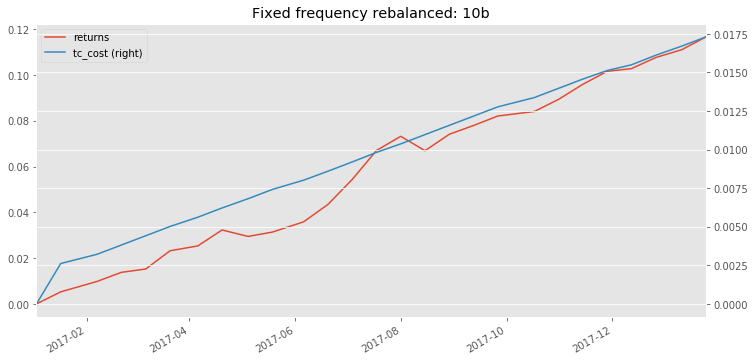

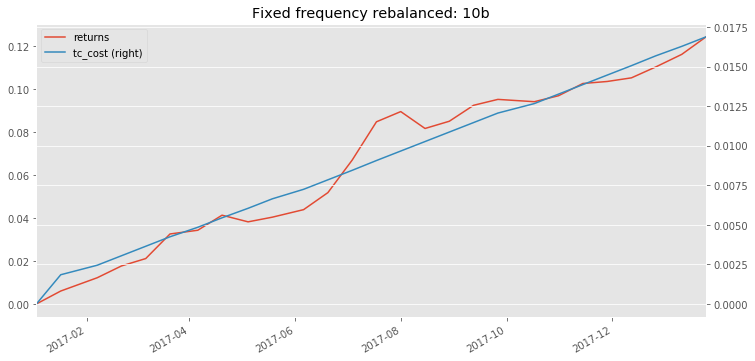

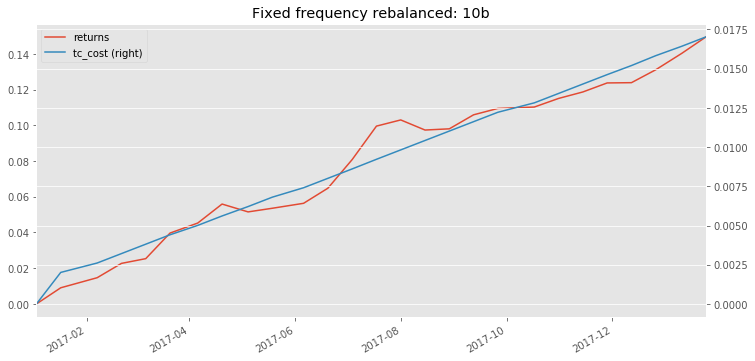

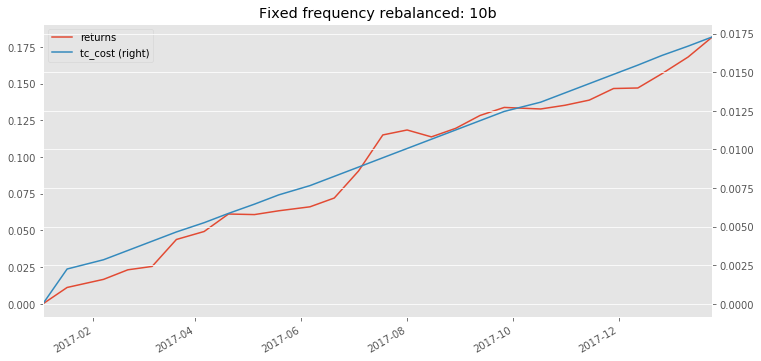

In [51]:
# Predicting and re-balance phase

weight_gaps = [0.005, 0.010, 0.015, 0.020]

model1_weight = 1.0
model2_weight = 0.5

factor_groups = const_model_factor_data.groupby('trade_date')
industry_group = industry_data.groupby('trade_date')
constraint_risk = ['SIZE', 'LEVERAGE'] + industries_list
turn_over_target_base = 0.30
size_risk_lower = 0
size_risk_upper = 0
benchmark_total_lower = 0.8
benchmark_total_upper = 1.
industry_lower = 1.
industry_upper = 1.

for s_i, weight_gap in enumerate(weight_gaps):
    print("start {0} weight gap simulation ...".format(weight_gap))

    rets = []
    turn_overs = []
    leverags = []
    previous_pos = pd.DataFrame()

    index_dates = []

    for i, value in enumerate(factor_groups):
        date = value[0]
        data = value[1]
        ref_date = date.strftime('%Y-%m-%d')

        total_data = data.fillna(data[model_features_keys].median())
        alpha_logger.info('{0}: {1}'.format(date, len(total_data)))
        risk_exp = total_data[neutralize_risk].values.astype(float)
        benchmark_w = total_data.weight.values
        
        this_industry_data = industry_group.get_group(date)
        
        total_data = pd.merge(total_data, this_industry_data, on=['trade_date', 'code'])
        constraint_exp = total_data[constraint_risk].values
        industry = total_data.industry_name.values
        risk_exp_expand = np.concatenate((constraint_exp, np.ones((len(risk_exp), 1))), axis=1).astype(float)

        risk_names = constraint_risk + ['total']
        risk_target = risk_exp_expand.T @ benchmark_w

        lbound = np.maximum(0., benchmark_w - weight_gap)  # np.zeros(len(total_data))
        ubound = weight_gap + benchmark_w

        is_in_benchmark = (benchmark_w > 0.).astype(float)

        risk_exp_expand = np.concatenate((risk_exp_expand, is_in_benchmark.reshape((-1, 1))), axis=1).astype(float)
        risk_names.append('benchmark_total')

        constraint = Constraints(risk_exp_expand, risk_names)

        for j, name in enumerate(risk_names):
            if name == 'total':
                constraint.set_constraints(name,
                                           lower_bound=risk_target[j],
                                           upper_bound=risk_target[j])
            elif name == 'SIZE':
                base_target = abs(risk_target[j])
                constraint.set_constraints(name,
                                           lower_bound=risk_target[j] + base_target * size_risk_lower,
                                           upper_bound=risk_target[j] + base_target * size_risk_upper)
            elif name == 'benchmark_total':
                base_target = benchmark_w.sum()
                constraint.set_constraints(name,
                                           lower_bound=benchmark_total_lower * base_target,
                                           upper_bound=benchmark_total_upper * base_target)
            else:
                constraint.set_constraints(name,
                                           lower_bound=risk_target[j] * industry_lower,
                                           upper_bound=risk_target[j] * industry_upper)
                
        values = total_data[model_features_keys].dropna()
        if values.empty:
            continue
        
        factor_values = factor_processing(total_data[model_features_keys].values,
                                          pre_process=[winsorize_normal, standardize],
                                          risk_factors=risk_exp,
                                          post_process=[winsorize_normal, standardize])

        # const linear model
        er1 = const_model.predict(factor_values)
        
        try:
            model = xgb_models_series.ix[date]
        except KeyError:
            alpha_logger.info("model is not available. Omit this date")
            continue
            
        index_dates.append(date)

        x = predict_x[date]
        this_predict_code = predict_code[date]
        er2 = model.predict(x)

        # combine model
        er1_table = pd.DataFrame({'er1': er1, 'code': total_data.code.values})
        er2_table = pd.DataFrame({'er2': er2, 'code': this_predict_code})
        er_table = pd.merge(er1_table, er2_table, on=['code'], how='left').fillna(0)

        er1 = er_table.er1.values
        er2 = er_table.er2.values
        
        if er2.std() > 0:
            print('using backbone model and alpha model')
            er = model1_weight * er1 / er1.std() +  model2_weight * er2 / er2.std()
        else:
            print('using only backbone modedl')
            er = model1_weight * er1
            
        codes = total_data['code'].values

        if previous_pos.empty:
            current_position = None
            turn_over_target = None
        else:
            previous_pos.set_index('code', inplace=True)
            remained_pos = previous_pos.loc[codes]

            remained_pos.fillna(0., inplace=True)
            turn_over_target = turn_over_target_base
            current_position = remained_pos.weight.values

        try:
            target_pos, _ = er_portfolio_analysis(er,
                                                  industry,
                                                  None,
                                                  constraint,
                                                  False,
                                                  benchmark_w,
                                                  method=method,
                                                  turn_over_target=turn_over_target,
                                                  current_position=current_position,
                                                  lbound=lbound,
                                                  ubound=ubound)
        except ValueError:
            alpha_logger.info('{0} full re-balance'.format(date))
            target_pos, _ = er_portfolio_analysis(er,
                                                  industry,
                                                  None,
                                                  constraint,
                                                  False,
                                                  benchmark_w,
                                                  method=method,
                                                  lbound=lbound,
                                                  ubound=ubound)

        target_pos['code'] = total_data['code'].values

        turn_over, executed_pos = executor.execute(target_pos=target_pos)

        executed_codes = executed_pos.code.tolist()
        dx_returns = engine.fetch_dx_return(date, executed_codes, horizon=horizon, offset=1)

        result = pd.merge(executed_pos, total_data[['code', 'weight']], on=['code'], how='inner')
        result = pd.merge(result, dx_returns, on=['code'])

        leverage = result.weight_x.abs().sum()

        ret = result.weight_x.values @ (np.exp(result.dx.values) - 1.)
        rets.append(np.log(1. + ret))
        executor.set_current(executed_pos)
        turn_overs.append(turn_over)
        leverags.append(leverage)

        previous_pos = executed_pos
        alpha_logger.info('{0} is finished'.format(date))

    ret_df = pd.DataFrame({'returns': rets, 'turn_over': turn_overs, 'leverage': leverags}, index=index_dates)

    # index return
    index_return = engine.fetch_dx_return_index_range(benchmark_code, dates=ref_dates, horizon=horizon,
                                                      offset=1).set_index('trade_date')
    ret_df['index'] = index_return['dx']

    ret_df.loc[advanceDateByCalendar('china.sse', ref_dates[-1], frequency)] = 0.
    ret_df = ret_df.shift(1)
    ret_df.iloc[0] = 0.
    ret_df['tc_cost'] = ret_df.turn_over * 0.002
    ret_df['returns'] = ret_df['leverage'] * (ret_df['returns'] - ret_df['index'])

    ret_df[['returns', 'tc_cost']].cumsum().plot(figsize=(12, 6),
                                                 title='Fixed frequency rebalanced: {0}'.format(frequency),
                                                 secondary_y='tc_cost')

    ret_df['ret_after_tc'] = ret_df['returns'] - ret_df['tc_cost']
    

    sharp_calc = MovingSharp(49)
    drawdown_calc = MovingMaxDrawdown(49)
    max_drawdown_calc = MovingMaxDrawdown(len(ret_df))

    res_df = pd.DataFrame(columns=['daily_return', 'cum_ret', 'sharp', 'drawdown', 'max_drawn', 'leverage'])

    total_returns = 0.

    for i, ret in enumerate(ret_df['ret_after_tc']):
        date = ret_df.index[i]
        total_returns += ret
        sharp_calc.push({'ret': ret, 'riskFree': 0.})
        drawdown_calc.push({'ret': ret})
        max_drawdown_calc.push({'ret': ret})

        res_df.loc[date, 'daily_return'] = ret
        res_df.loc[date, 'cum_ret'] = total_returns
        res_df.loc[date, 'drawdown'] = drawdown_calc.result()[0]
        res_df.loc[date, 'max_drawn'] = max_drawdown_calc.result()[0]
        res_df.loc[date, 'leverage'] = ret_df.loc[date, 'leverage']

        if i < 10:
            res_df.loc[date, 'sharp'] = 0.
        else:
            res_df.loc[date, 'sharp'] = sharp_calc.result() * np.sqrt(49)

    res_df.to_csv('hs300_rf2_{0}.csv'.format(int(s_i)))

In [52]:
index_return

,code,dx
trade_date,,
2017-01-03,300,-0.008629
2017-01-17,300,0.013057
2017-02-07,300,0.030984
2017-02-21,300,-0.011829
2017-03-07,300,0.000390
2017-03-21,300,0.019344
2017-04-06,300,-0.014495
2017-04-20,300,-0.031634
2017-05-05,300,0.015496


## Lasso Regression
----------

In [53]:
"""
Training phase
"""

lasso_models_series = pd.Series()
previous_model = None

for ref_date in ref_dates:
    x = train_x[ref_date]
    y = train_y[ref_date]
    if len(x) > 5 * len(model_features_keys):
        model = LassoRegression(alpha=0.01, features=model_features_keys, fit_intercept=True) 
        model.fit(x, y)
        lasso_models_series.loc[ref_date] = model
        previous_model = copy.deepcopy(model)
    else:
        models_series.loc[ref_date] = previous_model
    
    alpha_logger.info('trade_date: {0} with {1} obs training finished'.format(ref_date, len(x)))

2018-01-24 19:10:02,206 - ALPHA_MIND - INFO - trade_date: 2017-01-03 00:00:00 with 11339 obs training finished
2018-01-24 19:10:02,211 - ALPHA_MIND - INFO - trade_date: 2017-01-17 00:00:00 with 11347 obs training finished
2018-01-24 19:10:02,216 - ALPHA_MIND - INFO - trade_date: 2017-02-07 00:00:00 with 11352 obs training finished
2018-01-24 19:10:02,222 - ALPHA_MIND - INFO - trade_date: 2017-02-21 00:00:00 with 11353 obs training finished
2018-01-24 19:10:02,228 - ALPHA_MIND - INFO - trade_date: 2017-03-07 00:00:00 with 11345 obs training finished
2018-01-24 19:10:02,233 - ALPHA_MIND - INFO - trade_date: 2017-03-21 00:00:00 with 11326 obs training finished
2018-01-24 19:10:02,238 - ALPHA_MIND - INFO - trade_date: 2017-04-06 00:00:00 with 11297 obs training finished
2018-01-24 19:10:02,245 - ALPHA_MIND - INFO - trade_date: 2017-04-20 00:00:00 with 11283 obs training finished
2018-01-24 19:10:02,250 - ALPHA_MIND - INFO - trade_date: 2017-05-05 00:00:00 with 11277 obs training finished
2

2018-01-24 19:10:03,337 - ALPHA_MIND - INFO - 2017-01-03 00:00:00: 800


start 0.005 weight gap simulation ...
using backbone model and alpha model


D:\ProgramData\IntelPython3_2018\lib\site-packages\ipykernel_launcher.py:81: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
2018-01-24 19:10:03,567 - ALPHA_MIND - INFO - 2017-01-03 00:00:00 is finished
2018-01-24 19:10:03,573 - ALPHA_MIND - INFO - 2017-01-17 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:10:03,864 - ALPHA_MIND - INFO - 2017-01-17 00:00:00 is finished
2018-01-24 19:10:03,869 - ALPHA_MIND - INFO - 2017-02-07 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:10:04,181 - ALPHA_MIND - INFO - 2017-02-07 00:00:00 is finished
2018-01-24 19:10:04,187 - ALPHA_MIND - INFO - 2017-02-21 00:00:00: 799


using backbone model and alpha model


2018-01-24 19:10:04,498 - ALPHA_MIND - INFO - 2017-02-21 00:00:00 is finished
2018-01-24 19:10:04,503 - ALPHA_MIND - INFO - 2017-03-07 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:10:04,817 - ALPHA_MIND - INFO - 2017-03-07 00:00:00 is finished
2018-01-24 19:10:04,822 - ALPHA_MIND - INFO - 2017-03-21 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:10:05,116 - ALPHA_MIND - INFO - 2017-03-21 00:00:00 is finished
2018-01-24 19:10:05,121 - ALPHA_MIND - INFO - 2017-04-06 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:10:05,434 - ALPHA_MIND - INFO - 2017-04-06 00:00:00 is finished
2018-01-24 19:10:05,439 - ALPHA_MIND - INFO - 2017-04-20 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:10:05,744 - ALPHA_MIND - INFO - 2017-04-20 00:00:00 is finished
2018-01-24 19:10:05,749 - ALPHA_MIND - INFO - 2017-05-05 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:10:06,066 - ALPHA_MIND - INFO - 2017-05-05 00:00:00 is finished
2018-01-24 19:10:06,071 - ALPHA_MIND - INFO - 2017-05-19 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:10:06,383 - ALPHA_MIND - INFO - 2017-05-19 00:00:00 is finished
2018-01-24 19:10:06,390 - ALPHA_MIND - INFO - 2017-06-06 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:10:06,683 - ALPHA_MIND - INFO - 2017-06-06 00:00:00 is finished
2018-01-24 19:10:06,687 - ALPHA_MIND - INFO - 2017-06-20 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:10:07,089 - ALPHA_MIND - INFO - 2017-06-20 00:00:00 is finished
2018-01-24 19:10:07,094 - ALPHA_MIND - INFO - 2017-07-04 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:10:07,408 - ALPHA_MIND - INFO - 2017-07-04 00:00:00 is finished
2018-01-24 19:10:07,413 - ALPHA_MIND - INFO - 2017-07-18 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:10:07,720 - ALPHA_MIND - INFO - 2017-07-18 00:00:00 is finished
2018-01-24 19:10:07,724 - ALPHA_MIND - INFO - 2017-08-01 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:10:08,039 - ALPHA_MIND - INFO - 2017-08-01 00:00:00 is finished
2018-01-24 19:10:08,044 - ALPHA_MIND - INFO - 2017-08-15 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:10:08,361 - ALPHA_MIND - INFO - 2017-08-15 00:00:00 is finished
2018-01-24 19:10:08,365 - ALPHA_MIND - INFO - 2017-08-29 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:10:08,670 - ALPHA_MIND - INFO - 2017-08-29 00:00:00 is finished
2018-01-24 19:10:08,675 - ALPHA_MIND - INFO - 2017-09-12 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:10:08,996 - ALPHA_MIND - INFO - 2017-09-12 00:00:00 is finished
2018-01-24 19:10:09,000 - ALPHA_MIND - INFO - 2017-09-26 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:10:09,306 - ALPHA_MIND - INFO - 2017-09-26 00:00:00 is finished
2018-01-24 19:10:09,311 - ALPHA_MIND - INFO - 2017-10-17 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:10:09,623 - ALPHA_MIND - INFO - 2017-10-17 00:00:00 is finished
2018-01-24 19:10:09,628 - ALPHA_MIND - INFO - 2017-10-31 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:10:09,943 - ALPHA_MIND - INFO - 2017-10-31 00:00:00 is finished
2018-01-24 19:10:09,948 - ALPHA_MIND - INFO - 2017-11-14 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:10:10,260 - ALPHA_MIND - INFO - 2017-11-14 00:00:00 is finished
2018-01-24 19:10:10,266 - ALPHA_MIND - INFO - 2017-11-28 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:10:10,582 - ALPHA_MIND - INFO - 2017-11-28 00:00:00 is finished
2018-01-24 19:10:10,587 - ALPHA_MIND - INFO - 2017-12-12 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:10:10,902 - ALPHA_MIND - INFO - 2017-12-12 00:00:00 is finished
2018-01-24 19:10:10,907 - ALPHA_MIND - INFO - 2017-12-26 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:10:11,238 - ALPHA_MIND - INFO - 2017-12-26 00:00:00 is finished
2018-01-24 19:10:11,243 - ALPHA_MIND - INFO - 2018-01-10 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:10:11,532 - ALPHA_MIND - INFO - 2018-01-10 00:00:00 is finished
2018-01-24 19:10:11,785 - ALPHA_MIND - INFO - 2017-01-03 00:00:00: 800


start 0.01 weight gap simulation ...
using backbone model and alpha model


2018-01-24 19:10:12,002 - ALPHA_MIND - INFO - 2017-01-03 00:00:00 is finished
2018-01-24 19:10:12,006 - ALPHA_MIND - INFO - 2017-01-17 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:10:12,303 - ALPHA_MIND - INFO - 2017-01-17 00:00:00 is finished
2018-01-24 19:10:12,309 - ALPHA_MIND - INFO - 2017-02-07 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:10:12,611 - ALPHA_MIND - INFO - 2017-02-07 00:00:00 is finished
2018-01-24 19:10:12,616 - ALPHA_MIND - INFO - 2017-02-21 00:00:00: 799


using backbone model and alpha model


2018-01-24 19:10:12,910 - ALPHA_MIND - INFO - 2017-02-21 00:00:00 is finished
2018-01-24 19:10:12,916 - ALPHA_MIND - INFO - 2017-03-07 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:10:13,228 - ALPHA_MIND - INFO - 2017-03-07 00:00:00 is finished
2018-01-24 19:10:13,234 - ALPHA_MIND - INFO - 2017-03-21 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:10:13,538 - ALPHA_MIND - INFO - 2017-03-21 00:00:00 is finished
2018-01-24 19:10:13,543 - ALPHA_MIND - INFO - 2017-04-06 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:10:13,863 - ALPHA_MIND - INFO - 2017-04-06 00:00:00 is finished
2018-01-24 19:10:13,867 - ALPHA_MIND - INFO - 2017-04-20 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:10:14,181 - ALPHA_MIND - INFO - 2017-04-20 00:00:00 is finished
2018-01-24 19:10:14,186 - ALPHA_MIND - INFO - 2017-05-05 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:10:14,508 - ALPHA_MIND - INFO - 2017-05-05 00:00:00 is finished
2018-01-24 19:10:14,513 - ALPHA_MIND - INFO - 2017-05-19 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:10:14,825 - ALPHA_MIND - INFO - 2017-05-19 00:00:00 is finished
2018-01-24 19:10:14,830 - ALPHA_MIND - INFO - 2017-06-06 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:10:15,118 - ALPHA_MIND - INFO - 2017-06-06 00:00:00 is finished
2018-01-24 19:10:15,123 - ALPHA_MIND - INFO - 2017-06-20 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:10:15,446 - ALPHA_MIND - INFO - 2017-06-20 00:00:00 is finished
2018-01-24 19:10:15,452 - ALPHA_MIND - INFO - 2017-07-04 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:10:15,842 - ALPHA_MIND - INFO - 2017-07-04 00:00:00 is finished
2018-01-24 19:10:15,847 - ALPHA_MIND - INFO - 2017-07-18 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:10:16,154 - ALPHA_MIND - INFO - 2017-07-18 00:00:00 is finished
2018-01-24 19:10:16,159 - ALPHA_MIND - INFO - 2017-08-01 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:10:16,471 - ALPHA_MIND - INFO - 2017-08-01 00:00:00 is finished
2018-01-24 19:10:16,476 - ALPHA_MIND - INFO - 2017-08-15 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:10:16,785 - ALPHA_MIND - INFO - 2017-08-15 00:00:00 is finished
2018-01-24 19:10:16,791 - ALPHA_MIND - INFO - 2017-08-29 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:10:17,092 - ALPHA_MIND - INFO - 2017-08-29 00:00:00 is finished
2018-01-24 19:10:17,097 - ALPHA_MIND - INFO - 2017-09-12 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:10:17,407 - ALPHA_MIND - INFO - 2017-09-12 00:00:00 is finished
2018-01-24 19:10:17,411 - ALPHA_MIND - INFO - 2017-09-26 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:10:17,709 - ALPHA_MIND - INFO - 2017-09-26 00:00:00 is finished
2018-01-24 19:10:17,714 - ALPHA_MIND - INFO - 2017-10-17 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:10:18,013 - ALPHA_MIND - INFO - 2017-10-17 00:00:00 is finished
2018-01-24 19:10:18,018 - ALPHA_MIND - INFO - 2017-10-31 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:10:18,344 - ALPHA_MIND - INFO - 2017-10-31 00:00:00 is finished
2018-01-24 19:10:18,348 - ALPHA_MIND - INFO - 2017-11-14 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:10:18,658 - ALPHA_MIND - INFO - 2017-11-14 00:00:00 is finished
2018-01-24 19:10:18,663 - ALPHA_MIND - INFO - 2017-11-28 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:10:18,971 - ALPHA_MIND - INFO - 2017-11-28 00:00:00 is finished
2018-01-24 19:10:18,975 - ALPHA_MIND - INFO - 2017-12-12 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:10:19,290 - ALPHA_MIND - INFO - 2017-12-12 00:00:00 is finished
2018-01-24 19:10:19,296 - ALPHA_MIND - INFO - 2017-12-26 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:10:19,623 - ALPHA_MIND - INFO - 2017-12-26 00:00:00 is finished
2018-01-24 19:10:19,628 - ALPHA_MIND - INFO - 2018-01-10 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:10:19,918 - ALPHA_MIND - INFO - 2018-01-10 00:00:00 is finished
2018-01-24 19:10:20,092 - ALPHA_MIND - INFO - 2017-01-03 00:00:00: 800


start 0.015 weight gap simulation ...
using backbone model and alpha model


2018-01-24 19:10:20,400 - ALPHA_MIND - INFO - 2017-01-03 00:00:00 is finished
2018-01-24 19:10:20,405 - ALPHA_MIND - INFO - 2017-01-17 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:10:20,698 - ALPHA_MIND - INFO - 2017-01-17 00:00:00 is finished
2018-01-24 19:10:20,704 - ALPHA_MIND - INFO - 2017-02-07 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:10:21,025 - ALPHA_MIND - INFO - 2017-02-07 00:00:00 is finished
2018-01-24 19:10:21,030 - ALPHA_MIND - INFO - 2017-02-21 00:00:00: 799


using backbone model and alpha model


2018-01-24 19:10:21,336 - ALPHA_MIND - INFO - 2017-02-21 00:00:00 is finished
2018-01-24 19:10:21,341 - ALPHA_MIND - INFO - 2017-03-07 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:10:21,653 - ALPHA_MIND - INFO - 2017-03-07 00:00:00 is finished
2018-01-24 19:10:21,658 - ALPHA_MIND - INFO - 2017-03-21 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:10:21,962 - ALPHA_MIND - INFO - 2017-03-21 00:00:00 is finished
2018-01-24 19:10:21,968 - ALPHA_MIND - INFO - 2017-04-06 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:10:22,277 - ALPHA_MIND - INFO - 2017-04-06 00:00:00 is finished
2018-01-24 19:10:22,282 - ALPHA_MIND - INFO - 2017-04-20 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:10:22,594 - ALPHA_MIND - INFO - 2017-04-20 00:00:00 is finished
2018-01-24 19:10:22,599 - ALPHA_MIND - INFO - 2017-05-05 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:10:22,903 - ALPHA_MIND - INFO - 2017-05-05 00:00:00 is finished
2018-01-24 19:10:22,909 - ALPHA_MIND - INFO - 2017-05-19 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:10:23,215 - ALPHA_MIND - INFO - 2017-05-19 00:00:00 is finished
2018-01-24 19:10:23,221 - ALPHA_MIND - INFO - 2017-06-06 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:10:23,517 - ALPHA_MIND - INFO - 2017-06-06 00:00:00 is finished
2018-01-24 19:10:23,523 - ALPHA_MIND - INFO - 2017-06-20 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:10:23,831 - ALPHA_MIND - INFO - 2017-06-20 00:00:00 is finished
2018-01-24 19:10:23,836 - ALPHA_MIND - INFO - 2017-07-04 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:10:24,135 - ALPHA_MIND - INFO - 2017-07-04 00:00:00 is finished
2018-01-24 19:10:24,140 - ALPHA_MIND - INFO - 2017-07-18 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:10:24,452 - ALPHA_MIND - INFO - 2017-07-18 00:00:00 is finished
2018-01-24 19:10:24,457 - ALPHA_MIND - INFO - 2017-08-01 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:10:24,771 - ALPHA_MIND - INFO - 2017-08-01 00:00:00 is finished
2018-01-24 19:10:24,776 - ALPHA_MIND - INFO - 2017-08-15 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:10:25,088 - ALPHA_MIND - INFO - 2017-08-15 00:00:00 is finished
2018-01-24 19:10:25,092 - ALPHA_MIND - INFO - 2017-08-29 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:10:25,475 - ALPHA_MIND - INFO - 2017-08-29 00:00:00 is finished
2018-01-24 19:10:25,481 - ALPHA_MIND - INFO - 2017-09-12 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:10:25,793 - ALPHA_MIND - INFO - 2017-09-12 00:00:00 is finished
2018-01-24 19:10:25,798 - ALPHA_MIND - INFO - 2017-09-26 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:10:26,090 - ALPHA_MIND - INFO - 2017-09-26 00:00:00 is finished
2018-01-24 19:10:26,095 - ALPHA_MIND - INFO - 2017-10-17 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:10:26,411 - ALPHA_MIND - INFO - 2017-10-17 00:00:00 is finished
2018-01-24 19:10:26,415 - ALPHA_MIND - INFO - 2017-10-31 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:10:26,728 - ALPHA_MIND - INFO - 2017-10-31 00:00:00 is finished
2018-01-24 19:10:26,734 - ALPHA_MIND - INFO - 2017-11-14 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:10:27,056 - ALPHA_MIND - INFO - 2017-11-14 00:00:00 is finished
2018-01-24 19:10:27,062 - ALPHA_MIND - INFO - 2017-11-28 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:10:27,358 - ALPHA_MIND - INFO - 2017-11-28 00:00:00 is finished
2018-01-24 19:10:27,363 - ALPHA_MIND - INFO - 2017-12-12 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:10:27,696 - ALPHA_MIND - INFO - 2017-12-12 00:00:00 is finished
2018-01-24 19:10:27,701 - ALPHA_MIND - INFO - 2017-12-26 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:10:28,004 - ALPHA_MIND - INFO - 2017-12-26 00:00:00 is finished
2018-01-24 19:10:28,010 - ALPHA_MIND - INFO - 2018-01-10 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:10:28,289 - ALPHA_MIND - INFO - 2018-01-10 00:00:00 is finished
2018-01-24 19:10:28,461 - ALPHA_MIND - INFO - 2017-01-03 00:00:00: 800


start 0.02 weight gap simulation ...
using backbone model and alpha model


2018-01-24 19:10:28,678 - ALPHA_MIND - INFO - 2017-01-03 00:00:00 is finished
2018-01-24 19:10:28,683 - ALPHA_MIND - INFO - 2017-01-17 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:10:28,977 - ALPHA_MIND - INFO - 2017-01-17 00:00:00 is finished
2018-01-24 19:10:28,981 - ALPHA_MIND - INFO - 2017-02-07 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:10:29,285 - ALPHA_MIND - INFO - 2017-02-07 00:00:00 is finished
2018-01-24 19:10:29,290 - ALPHA_MIND - INFO - 2017-02-21 00:00:00: 799


using backbone model and alpha model


2018-01-24 19:10:29,683 - ALPHA_MIND - INFO - 2017-02-21 00:00:00 is finished
2018-01-24 19:10:29,688 - ALPHA_MIND - INFO - 2017-03-07 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:10:29,987 - ALPHA_MIND - INFO - 2017-03-07 00:00:00 is finished
2018-01-24 19:10:29,993 - ALPHA_MIND - INFO - 2017-03-21 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:10:30,282 - ALPHA_MIND - INFO - 2017-03-21 00:00:00 is finished
2018-01-24 19:10:30,286 - ALPHA_MIND - INFO - 2017-04-06 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:10:30,600 - ALPHA_MIND - INFO - 2017-04-06 00:00:00 is finished
2018-01-24 19:10:30,606 - ALPHA_MIND - INFO - 2017-04-20 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:10:30,909 - ALPHA_MIND - INFO - 2017-04-20 00:00:00 is finished
2018-01-24 19:10:30,916 - ALPHA_MIND - INFO - 2017-05-05 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:10:31,234 - ALPHA_MIND - INFO - 2017-05-05 00:00:00 is finished
2018-01-24 19:10:31,240 - ALPHA_MIND - INFO - 2017-05-19 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:10:31,551 - ALPHA_MIND - INFO - 2017-05-19 00:00:00 is finished
2018-01-24 19:10:31,557 - ALPHA_MIND - INFO - 2017-06-06 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:10:31,860 - ALPHA_MIND - INFO - 2017-06-06 00:00:00 is finished
2018-01-24 19:10:31,865 - ALPHA_MIND - INFO - 2017-06-20 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:10:32,168 - ALPHA_MIND - INFO - 2017-06-20 00:00:00 is finished
2018-01-24 19:10:32,173 - ALPHA_MIND - INFO - 2017-07-04 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:10:32,480 - ALPHA_MIND - INFO - 2017-07-04 00:00:00 is finished
2018-01-24 19:10:32,486 - ALPHA_MIND - INFO - 2017-07-18 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:10:32,799 - ALPHA_MIND - INFO - 2017-07-18 00:00:00 is finished
2018-01-24 19:10:32,804 - ALPHA_MIND - INFO - 2017-08-01 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:10:33,111 - ALPHA_MIND - INFO - 2017-08-01 00:00:00 is finished
2018-01-24 19:10:33,116 - ALPHA_MIND - INFO - 2017-08-15 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:10:33,426 - ALPHA_MIND - INFO - 2017-08-15 00:00:00 is finished
2018-01-24 19:10:33,431 - ALPHA_MIND - INFO - 2017-08-29 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:10:33,744 - ALPHA_MIND - INFO - 2017-08-29 00:00:00 is finished
2018-01-24 19:10:33,749 - ALPHA_MIND - INFO - 2017-09-12 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:10:34,067 - ALPHA_MIND - INFO - 2017-09-12 00:00:00 is finished
2018-01-24 19:10:34,072 - ALPHA_MIND - INFO - 2017-09-26 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:10:34,380 - ALPHA_MIND - INFO - 2017-09-26 00:00:00 is finished
2018-01-24 19:10:34,385 - ALPHA_MIND - INFO - 2017-10-17 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:10:34,784 - ALPHA_MIND - INFO - 2017-10-17 00:00:00 is finished
2018-01-24 19:10:34,789 - ALPHA_MIND - INFO - 2017-10-31 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:10:35,099 - ALPHA_MIND - INFO - 2017-10-31 00:00:00 is finished
2018-01-24 19:10:35,104 - ALPHA_MIND - INFO - 2017-11-14 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:10:35,438 - ALPHA_MIND - INFO - 2017-11-14 00:00:00 is finished
2018-01-24 19:10:35,443 - ALPHA_MIND - INFO - 2017-11-28 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:10:35,745 - ALPHA_MIND - INFO - 2017-11-28 00:00:00 is finished
2018-01-24 19:10:35,750 - ALPHA_MIND - INFO - 2017-12-12 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:10:36,070 - ALPHA_MIND - INFO - 2017-12-12 00:00:00 is finished
2018-01-24 19:10:36,075 - ALPHA_MIND - INFO - 2017-12-26 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:10:36,390 - ALPHA_MIND - INFO - 2017-12-26 00:00:00 is finished
2018-01-24 19:10:36,395 - ALPHA_MIND - INFO - 2018-01-10 00:00:00: 800


using backbone model and alpha model


2018-01-24 19:10:36,682 - ALPHA_MIND - INFO - 2018-01-10 00:00:00 is finished


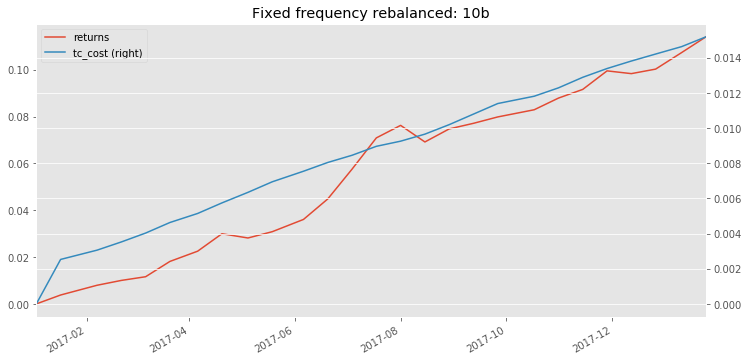

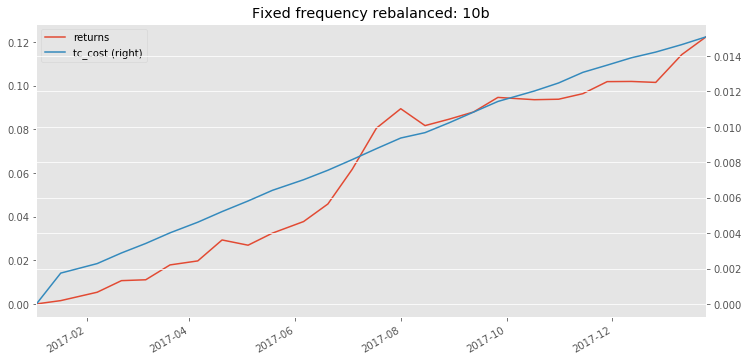

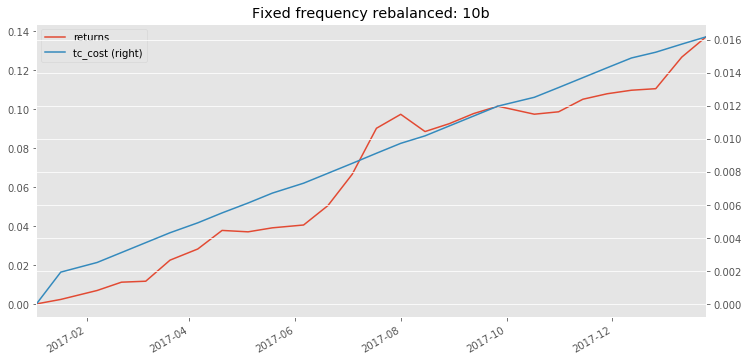

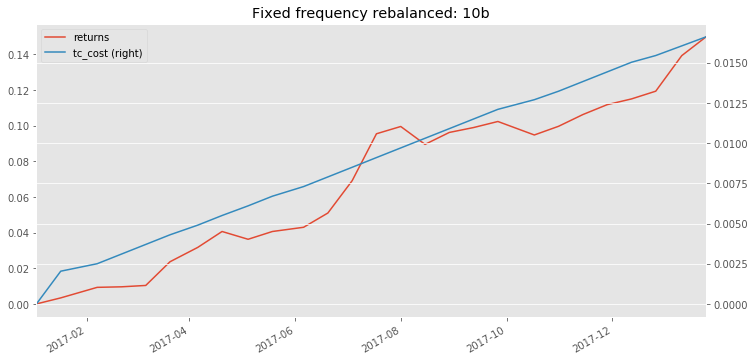

In [54]:
# Predicting and re-balance phase

weight_gaps = [0.005, 0.010, 0.015, 0.020]

model1_weight = 1.0
model2_weight = 0.5

factor_groups = const_model_factor_data.groupby('trade_date')

for s_i, weight_gap in enumerate(weight_gaps):
    print("start {0} weight gap simulation ...".format(weight_gap))

    rets = []
    turn_overs = []
    leverags = []
    previous_pos = pd.DataFrame()

    index_dates = []

    for i, value in enumerate(factor_groups):
        date = value[0]
        data = value[1]
        ref_date = date.strftime('%Y-%m-%d')

        total_data = data.fillna(data[model_features_keys].median())
        alpha_logger.info('{0}: {1}'.format(date, len(total_data)))
        risk_exp = total_data[neutralize_risk].values.astype(float)
        industry = total_data.industry_code.values
        benchmark_w = total_data.weight.values
        
        this_industry_data = industry_group.get_group(date)
        
        total_data = pd.merge(total_data, this_industry_data, on=['trade_date', 'code'])
        constraint_exp = total_data[constraint_risk].values
        industry = total_data.industry_name.values

        risk_exp_expand = np.concatenate((constraint_exp, np.ones((len(risk_exp), 1))), axis=1).astype(float)

        risk_names = constraint_risk + ['total']
        risk_target = risk_exp_expand.T @ benchmark_w

        lbound = np.maximum(0., benchmark_w - weight_gap)  # np.zeros(len(total_data))
        ubound = weight_gap + benchmark_w

        is_in_benchmark = (benchmark_w > 0.).astype(float)

        risk_exp_expand = np.concatenate((risk_exp_expand, is_in_benchmark.reshape((-1, 1))), axis=1).astype(float)
        risk_names.append('benchmark_total')

        constraint = Constraints(risk_exp_expand, risk_names)

        for j, name in enumerate(risk_names):
            if name == 'total':
                constraint.set_constraints(name,
                                           lower_bound=risk_target[j],
                                           upper_bound=risk_target[j])
            elif name == 'SIZE':
                base_target = abs(risk_target[j])
                constraint.set_constraints(name,
                                           lower_bound=risk_target[j] + base_target * size_risk_lower,
                                           upper_bound=risk_target[j] + base_target * size_risk_upper)
            elif name == 'benchmark_total':
                base_target = benchmark_w.sum()
                constraint.set_constraints(name,
                                           lower_bound=benchmark_total_lower * base_target,
                                           upper_bound=benchmark_total_upper * base_target)
            else:
                constraint.set_constraints(name,
                                           lower_bound=risk_target[j] * industry_lower,
                                           upper_bound=risk_target[j] * industry_upper)
        
        factor_values = factor_processing(total_data[model_features_keys].values,
                                          pre_process=[winsorize_normal, standardize],
                                          risk_factors=risk_exp,
                                          post_process=[winsorize_normal, standardize])

        # const linear model
        er1 = const_model.predict(factor_values)
        
        try:
            model = lasso_models_series.ix[date]
        except KeyError:
            alpha_logger.info("model is not available. Omit this date")
            continue
            
        index_dates.append(date)

        x = predict_x[date]
        this_predict_code = predict_code[date]
        er2 = model.predict(x)

        # combine model
        er1_table = pd.DataFrame({'er1': er1, 'code': total_data.code.values})
        er2_table = pd.DataFrame({'er2': er2, 'code': this_predict_code})
        er_table = pd.merge(er1_table, er2_table, on=['code'], how='left').fillna(0)

        er1 = er_table.er1.values
        er2 = er_table.er2.values
        
        if er2.std() > 0:
            print('using backbone model and alpha model')
            er = model1_weight * er1 / er1.std() +  model2_weight * er2 / er2.std()
        else:
            print('using only backbone modedl')
            er = model1_weight * er1
            
        codes = total_data['code'].values

        if previous_pos.empty:
            current_position = None
            turn_over_target = None
        else:
            previous_pos.set_index('code', inplace=True)
            remained_pos = previous_pos.loc[codes]

            remained_pos.fillna(0., inplace=True)
            turn_over_target = turn_over_target_base
            current_position = remained_pos.weight.values

        try:
            target_pos, _ = er_portfolio_analysis(er,
                                                  industry,
                                                  None,
                                                  constraint,
                                                  False,
                                                  benchmark_w,
                                                  method=method,
                                                  turn_over_target=turn_over_target,
                                                  current_position=current_position,
                                                  lbound=lbound,
                                                  ubound=ubound)
        except ValueError:
            alpha_logger.info('{0} full re-balance'.format(date))
            target_pos, _ = er_portfolio_analysis(er,
                                                  industry,
                                                  None,
                                                  constraint,
                                                  False,
                                                  benchmark_w,
                                                  method=method,
                                                  lbound=lbound,
                                                  ubound=ubound)

        target_pos['code'] = total_data['code'].values

        turn_over, executed_pos = executor.execute(target_pos=target_pos)

        executed_codes = executed_pos.code.tolist()
        dx_returns = engine.fetch_dx_return(date, executed_codes, horizon=horizon, offset=1)

        result = pd.merge(executed_pos, total_data[['code', 'weight']], on=['code'], how='inner')
        result = pd.merge(result, dx_returns, on=['code'])

        leverage = result.weight_x.abs().sum()

        ret = result.weight_x.values @ (np.exp(result.dx.values) - 1.)
        rets.append(np.log(1. + ret))
        executor.set_current(executed_pos)
        turn_overs.append(turn_over)
        leverags.append(leverage)

        previous_pos = executed_pos
        alpha_logger.info('{0} is finished'.format(date))

    ret_df = pd.DataFrame({'returns': rets, 'turn_over': turn_overs, 'leverage': leverags}, index=index_dates)

    # index return
    index_return = engine.fetch_dx_return_index_range(benchmark_code, dates=ref_dates, horizon=horizon,
                                                      offset=1).set_index('trade_date')
    ret_df['index'] = index_return['dx']

    ret_df.loc[advanceDateByCalendar('china.sse', ref_dates[-1], frequency)] = 0.
    ret_df = ret_df.shift(1)
    ret_df.iloc[0] = 0.
    ret_df['tc_cost'] = ret_df.turn_over * 0.002
    ret_df['returns'] = ret_df['leverage'] * (ret_df['returns'] - ret_df['index'])

    ret_df[['returns', 'tc_cost']].cumsum().plot(figsize=(12, 6),
                                                 title='Fixed frequency rebalanced: {0}'.format(frequency),
                                                 secondary_y='tc_cost')

    ret_df['ret_after_tc'] = ret_df['returns'] - ret_df['tc_cost']
    

    sharp_calc = MovingSharp(49)
    drawdown_calc = MovingMaxDrawdown(49)
    max_drawdown_calc = MovingMaxDrawdown(len(ret_df))

    res_df = pd.DataFrame(columns=['daily_return', 'cum_ret', 'sharp', 'drawdown', 'max_drawn', 'leverage'])

    total_returns = 0.

    for i, ret in enumerate(ret_df['ret_after_tc']):
        date = ret_df.index[i]
        total_returns += ret
        sharp_calc.push({'ret': ret, 'riskFree': 0.})
        drawdown_calc.push({'ret': ret})
        max_drawdown_calc.push({'ret': ret})

        res_df.loc[date, 'daily_return'] = ret
        res_df.loc[date, 'cum_ret'] = total_returns
        res_df.loc[date, 'drawdown'] = drawdown_calc.result()[0]
        res_df.loc[date, 'max_drawn'] = max_drawdown_calc.result()[0]
        res_df.loc[date, 'leverage'] = ret_df.loc[date, 'leverage']

        if i < 10:
            res_df.loc[date, 'sharp'] = 0.
        else:
            res_df.loc[date, 'sharp'] = sharp_calc.result() * np.sqrt(49)

    res_df.to_csv('hs300_rf_{0}.csv'.format(int(s_i)))